# Probabilistic Autoencode on LHCO data

## Import machine lerning libraries

In [1]:
import sys
import numpy as np
import pandas as pd

sys.path.append("../")

from pae.models.autoencoder import DenseAutoencoder
from pae.models.flows import MAF
from pae.models.nn import PaeBuilder

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as tfk

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from tensorflow.python.client import device_lib

devices = tf.config.list_physical_devices()
print("tensorflow", tf.__version__)
print("tensorflow-probability", tfp.__version__)
print("Available devices:", *[dev[1] for dev in devices])

SEED = 42
np.random.seed(SEED) 
tf.random.set_seed(SEED)

tensorflow 2.4.1
tensorflow-probability 0.12.1
Available devices: CPU GPU


## Plotting libraries 

In [4]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected = True)
pio.templates.default = "plotly_dark"


## Data loading and preprocessing

In [5]:
from pae.utils import load_json, dump_json

from pae.loaders.LHCO import ScalarLoaderLHCO, ImageLoaderLHCO, DatasetBuilder

x = ImageLoaderLHCO.from_json("pae/configs/loader/images_rnd.json")
mjj = ScalarLoaderLHCO.from_json("pae/configs/loader/scalar_mjj.json")
builder = DatasetBuilder(x, mjj)
builder.data_preparation(sample_sizes ={'sig':15_000, 'bkg': 110_000}, fit_key='bkg')
dataset = builder.make_dataset(train = {'bkg':100_000}, test={'sig':10_000, 'bkg': 10_000}, shuffle=True)

## Network creation

In [7]:
# from matplotlib.colors import LogNorm

# vmin = np.min([dataset[key].min() for key in ['x_train', 'x_test', 'x_valid']])
# vmax = np.max([dataset[key].max() for key in ['x_train', 'x_test', 'x_valid']])
# eps = 1e-6
# print(vmin, vmax)
# ln = LogNorm(vmin=eps, vmax=vmax)

# for key in ['x_train', 'x_test', 'x_valid']:
#     dataset[key] = ln(dataset[key][:,:,:,:2])+1e-6

0.0 3252.1333


In [10]:
vmin = np.min([dataset[key].min() for key in ['x_train', 'x_valid']])
vmax = np.max([dataset[key].max() for key in ['x_train', 'x_valid']])
eps = 1e-6
print(vmin, vmax)

def rescale(x):
    return x

for key in ['x_train', 'x_test', 'x_valid']:
    dataset[key] = rescale(dataset[key][:,:,:,:2])

0.0 3252.1333


In [6]:
dataset['x_test'].shape
dataset['x_train'].max()

3252.1333

In [14]:
from tensorflow.keras.models import Sequential
from pae.models.autoencoder import Autoencoder
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras import layers

class CNNAE(Autoencoder):
    def __init__(self, enc, dec, **kwargs):
        super().__init__(**kwargs)
        self.encoder = enc
        self.decoder = dec
        self.layers
    def call(self, inputs):
        """Run the inputs through the full autoencoder"""
        encoding = self.encoder(inputs)
        reconstructed = self.decoder(encoding)
        return reconstructed
    
    def encode(self, inputs):
        """Genereate the latent representation of the inputs"""
        return self.encoder.predict(inputs)

    def decode(self, encoding):
        """Reconstruct the inputs using a given latent representation"""
        return self.decoder.predict(encoding)

batch_size = 4
img_height = 32
img_width = 32
latent_dim = 25
n_channels = 2

l1 = 0#1e-3
l2 = 0#1e-3

enc = Sequential([
  layers.InputLayer(input_shape=(img_height, img_width, n_channels)),
  # layers.Conv2D(16, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  # layers.MaxPool2D(2),
  layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPool2D(2),
  layers.Conv2D(64, 3, strides=1, padding='valid', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPool2D(2),
  layers.Conv2D(1, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.Flatten(),
  layers.Dense(latent_dim, activation='tanh')
])

dec = Sequential([
  layers.InputLayer(input_shape=enc.layers[-1].output_shape[1:]),
  layers.Dense(49),
  layers.Reshape(target_shape=(7,7,1)),
  layers.UpSampling2D(2),
  layers.Conv2DTranspose(64, 3, strides=1, padding='valid', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.UpSampling2D(2),
  layers.Conv2DTranspose(32, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  # layers.UpSampling2D(2),
  # layers.Conv2DTranspose(16, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.Conv2DTranspose(n_channels, 3, strides=1, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
])

enc.summary()
dec.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        608       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 1)           577       
_________________________________________________________________
flatten_1 (Flatten)          (None, 49)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)               

In [15]:
from tensorflow.keras.models import Sequential

builder = PaeBuilder()

ae = CNNAE(enc,dec)

nf_config = {
    'n_dims':25, 
    'n_layers':6, 
    'units':[32 for i in range(4)]
}
optimizer_ae = {
    'lr': 0.001
}
optimizer_nf = {
    'lr': 0.005
}

builder._ae = ae
builder.make_ae_optimizer(tfk.optimizers.Adam, optimizer_ae)
builder.make_nf_model(MAF, nf_config)
builder.make_nf_optimizer(tfk.optimizers.Adam, optimizer_nf)
builder.compile_ae(loss='mean_squared_logarithmic_error')
builder.compile_nf()
pae = builder.pae

In [16]:
#w_kde_valid = fftkde.get_weights(dataset["mjj_valid"])
#w_gmm_valid = gmm.get_weights(dataset["mjj_valid"])

ae_train ={
    'batch_size':32,
    'epochs':40,
    #'sample_weight':w_kde,
    'validation_data':(dataset["x_valid"],dataset["x_valid"]),#,w_kde_valid),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        verbose=1
    )
}

nf_train ={
    'batch_size':100,
    'epochs':50,
    'validation_data':(dataset["x_valid"],dataset["x_valid"]),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        verbose=1
    )
}
with tf.device("/device:GPU:0"):
    %time pae.fit(dataset["x_train"],None,ae_train,nf_train)

#%time pae.ae.fit(x=dataset["x_train"], y=dataset["x_train"], **ae_train)

Epoch 1/40
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1303 - val_loss: 0.1167
Epoch 2/40
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1157 - val_loss: 0.1080
Epoch 3/40
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1063 - val_loss: 0.0998
Epoch 4/40
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0994 - val_loss: 0.0959
Epoch 5/40
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0956 - val_loss: 0.0930
Epoch 6/40
2500/2500 [==============================] - 10s 4ms/step - loss: 0.0931 - val_loss: 0.0914
Epoch 7/40
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0918 - val_loss: 0.0903
Epoch 8/40
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0905 - val_loss: 0.0894
Epoch 9/40
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0900 - val_loss: 0.0897
Epoch 10/40
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0

### Training metrics

In [17]:
from pae.plotting import loss_plot

fig = loss_plot(pae.history)
fig.show('vscode')

In [18]:
#with tf.device("/device:CPU:0"):
z_true = pae.ae.encode(dataset['x_train'])
z_sample = pae.nf.sample(dataset['x_train'].shape[0])

In [19]:
from pae.plotting import latent_space_plot
#pio.templates.default = "plotly"
fig = latent_space_plot(z_true, z_sample)
fig.show('vscode')

## Analysis

In [28]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

#img = pae.ae.decode(z_true[:100])
img = pae.ae.predict(dataset['x_train'][:100,:,:,:])


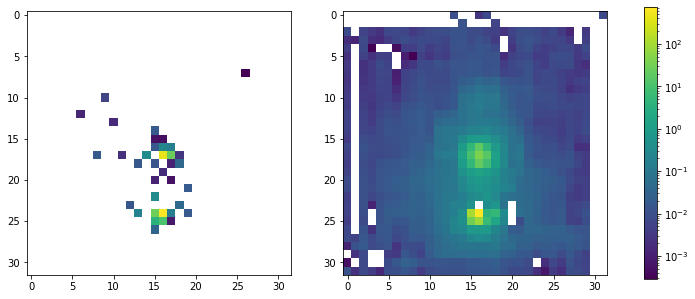

In [31]:
no=17
ch = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
for data, ax in zip([dataset['x_train'][no][:,:,ch], img[no][:,:,ch]], axes.flat):
    im = ax.imshow(data, norm=LogNorm())

fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()

# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plt.title('Background')
# im = plt.imshow(dataset['x_train'][no][:,:,ch])
# fig.colorbar(im)
# plt.subplot(1,2,2)
# plt.title('Reconstruction')
# plt.imshow(img[no][:,:,ch])
# plt.show()

In [42]:
def reco_error(x):
    return np.square(np.log(pae.ae.predict(x)+1)-np.log(x+1))

def anomaly_score(x):
    """Calculates the anomaly scores for the input data"""
    sigma = np.mean(reco_error(dataset['x_valid']), axis=0)**(-1)
    mse = np.square(pae.ae.predict(x)-x)
    z = pae.ae.encode(x)
    byz = pae.nf.inverse(z)
    detJ = pae.nf.inverse_log_det_jacobian(z)
    ascore = -0.5*np.mean(mse*sigma, axis=(1,2,3)) - \
            0.5*np.linalg.norm(byz,axis=1)**2 + detJ
    return ascore



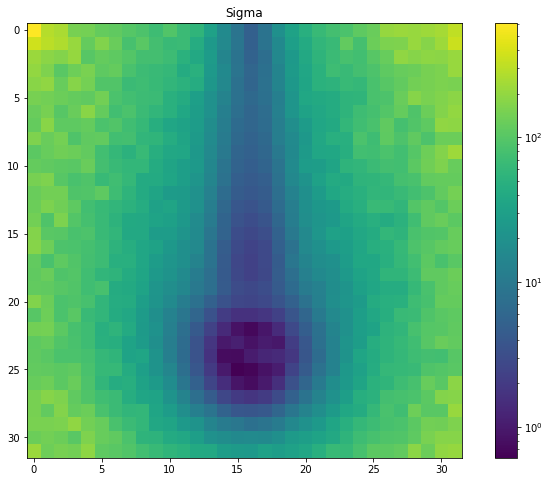

In [39]:
sigma = np.mean(reco_error(dataset['x_valid']), axis=0)**(-1)
fig, ax = plt.subplots(figsize=(12,8))
plt.title('Sigma')
im = plt.imshow(sigma[:,:,0], norm=LogNorm())
fig.colorbar(im, ax=ax)
plt.show()

In [40]:
with tf.device("/device:CPU:0"):
    sigma = np.mean(reco_error(dataset['x_valid']), axis = 0)**(-1)
    mse_test = reco_error(dataset['x_test'])
    test_mse = np.mean(mse_test*sigma, axis=(1,2,3))

    mse_train = reco_error(dataset['x_train'])
    train_mse = np.mean(mse_train*sigma, axis=(1,2,3))

In [43]:
with tf.device("/device:CPU:0"):
    test_ascore = -anomaly_score(dataset['x_test'])
    train_ascore = -anomaly_score(dataset['x_train'])

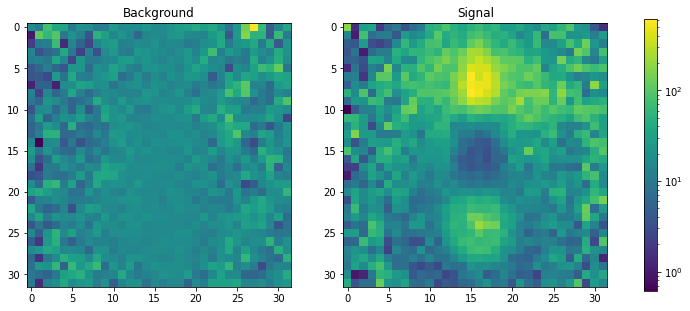

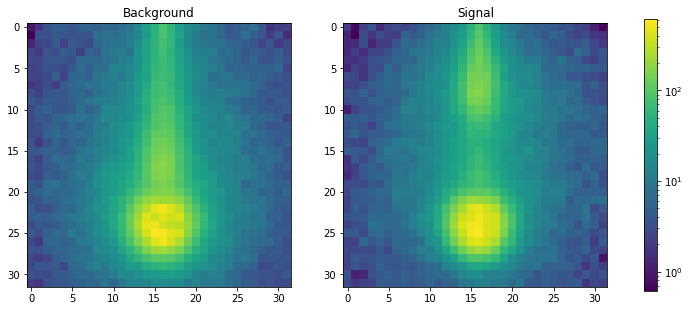

In [46]:

fig, axes = plt.subplots(ncols=2, figsize=(13,5))
axes[0].set_title('Background')
axes[0].imshow(np.mean(mse_test[10_000:,:,:]*sigma, axis=0)[:,:,0], norm=LogNorm())
axes[1].set_title('Signal')
axes[1].imshow(np.mean(mse_test[:10_000,:,:]*sigma, axis=0)[:,:,0], norm=LogNorm())
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(13,5))
axes[0].set_title('Background')
axes[0].imshow(np.mean(mse_test[10_000:,:,:], axis=0)[:,:,0], norm=LogNorm())
axes[1].set_title('Signal')
axes[1].imshow(np.mean(mse_test[:10_000,:,:], axis=0)[:,:,0], norm=LogNorm())
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

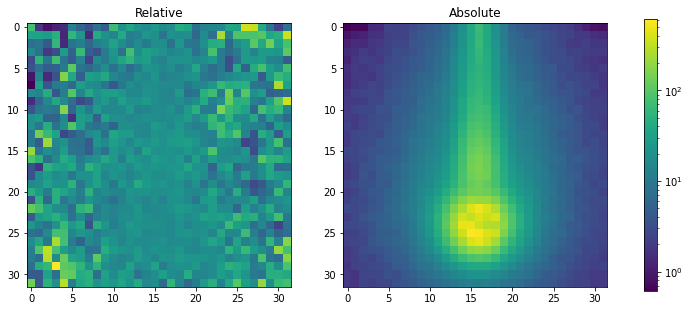

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(13,5))
axes[0].set_title('Relative')
axes[0].imshow(np.mean(mse_train*sigma, axis=0)[:,:,0], norm=LogNorm())
axes[1].set_title('Absolute')
axes[1].imshow(np.mean(mse_train, axis=0)[:,:,0], norm=LogNorm())
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

## Feature maps

(3, 3, 32, 64) (64,)


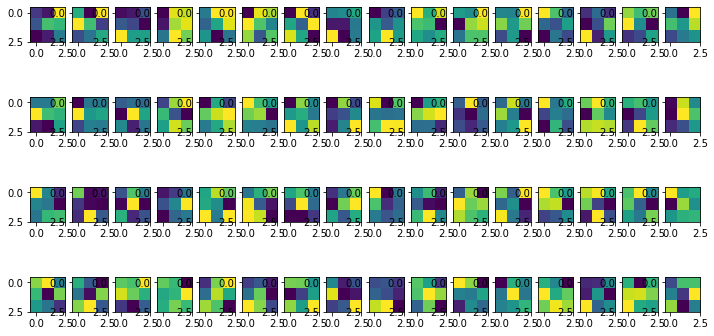

In [48]:
lno = 2
fno = 2
cno = 0

filters, biases = pae.ae.encoder.layers[lno].get_weights()
print(filters.shape, biases.shape)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
plt.figure(figsize=(12,8))
for fno in range(filters.shape[-1]):
    plt.subplot(5, filters.shape[-1]//4, fno+1)
    f = filters[:, :, :, fno]
    plt.imshow(f[:, :, cno])
plt.show()

## Plots

In [56]:
prc=95


fig = go.Figure()
fig.add_trace(go.Histogram(x=test_ascore[10_000:], name='Background', 
                           marker_color='steelblue', nbinsx=80),
             )
fig.add_trace(go.Histogram(x=test_ascore[:10_000], name='Signal', 
                           marker_color='darkorange', nbinsx=80),
             )


fig.update_layout(
    xaxis_title='Anomaly Score',
    title_text=r'Anomlay Score Distributions',
    barmode='stack',
    width=600)
fig.show('vscode')

In [59]:
from scipy.spatial.distance import jensenshannon
pio.templates.default = "presentation"
mjj = dataset['mjj_train']
max_prc = 99
score = train_ascore
n_full, b = np.histogram(mjj, bins=60, density=True)
js_div = {}

for prc in range(1, max_prc+1):
    x_prc = np.percentile(score, prc)
    i_prc = np.where(score >= x_prc)[0]
    n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
    js_div[prc] = jensenshannon(n_full,n_prc)

score = train_mse
js_div_mse = {}
for prc in range(1, max_prc+1):
    x_prc = np.percentile(score, prc)
    i_prc = np.where(score >= x_prc)[0]
    n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
    js_div_mse[prc] = jensenshannon(n_full,n_prc)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=list(js_div.keys()), y=list(js_div.values()), mode='lines',
        name="PAE ascore", line=dict(color="plum", width=3))
)
fig.add_trace(
    go.Scatter(x=list(js_div_mse.keys()), y=list(js_div_mse.values()), mode='lines',
        name="NMSE", line=dict(color="steelblue", width=3))
)


fig.update_layout(
    title_text = "Mass sculpting",
    xaxis_title = "Percentile Cut",
    yaxis_title = "Jensen–Shannon",
    margin={'l': 80, 'b': 40, 't': 40, 'r': 0},
    width=750, height=450

)
fig.show('vscode')
#fig.write_image("JS-plot.png")


In [64]:
from sklearn.metrics import roc_curve, auc
import plotly.express as px

def binarize(label):
    return 1 if label == 'sig' else 0
labels = np.array(list(map(binarize, dataset['labels_test'])))
#labels = np.concatenate([np.ones(10_000),np.zeros(10_000)])

fpr, tpr, _ = roc_curve(labels, test_ascore)
pae_auc = auc(1-fpr, tpr)

fpr_mse, tpr_mse, _ = roc_curve(labels, test_mse)
nmse_auc = auc(1-fpr_mse, tpr_mse)

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=tpr, y=1-fpr, mode='lines',
        name=f"PAE (AUC:{pae_auc:.2f})", line=dict(color="Plum", width=2))
)
fig.add_trace(
    go.Scatter(x=tpr_mse, y=1-fpr_mse, mode='lines',
        name=f"NMSE (AUC:{nmse_auc:.2f})", line=dict(color="steelblue", width=2))
)

fig.update_layout(
    width=500, height=500,
    xaxis_title = "Signal efficiency",
    yaxis_title = "Background Rejection",
    margin={'l': 60, 'b': 60, 't': 40, 'r': 0},
    legend = dict(x=0.1, y=0.05,
        traceorder='normal',
        font=dict(size=15)),
    title_text="ROC curves"
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
#fig.write_image("ROC2jet.png")
fig.show('vscode')